# Image classifier

In [ ]:
!pip install torch
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
from torch.nn.functional import relu
from torch.optim import Adam
import torchvision.models as models
from torch.utils.data import random_split,DataLoader
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,f1_score,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV,cross_validate,train_test_split,cross_val_score
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB,BernoulliNB,CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, NuSVC 
from sklearn.linear_model import LogisticRegression
from skimage.filters import sobel,laplace,prewitt
from sklearn.ensemble import VotingClassifier, StackingClassifier,BaggingClassifier,AdaBoostClassifier,RandomForestClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage import filters

## Dataset

In [ ]:
transformer = transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])

In [ ]:
train_set=torchvision.datasets.CIFAR10('./files/cifar10/', train=True, download=True,
                             transform=transformer)

test_set=torchvision.datasets.CIFAR10('./files/cifar10/', train=False, download=True,
                             transform=transformer)

batch_size_train= (int)(len(train_set)/10)
batch_size_test=(int)(len(test_set)/10)


170499072it [00:25, 6681314.90it/s]                                                                                    


Extracting ./files/cifar10/cifar-10-python.tar.gz to ./files/cifar10/
Files already downloaded and verified


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=batch_size_test, shuffle=True)

In [ ]:
train_enumerated = enumerate(train_loader)
batch_idx, (train_x, train_y) = next(train_enumerated)

test_enumerated = enumerate(test_loader)
batch_idx, (test_x, test_y) = next(test_enumerated)

In [ ]:
train_x.shape

torch.Size([5000, 3, 32, 32])

In [ ]:
train_x[1]

tensor([[[0.1922, 0.2000, 0.2078,  ..., 0.2627, 0.2667, 0.2706],
         [0.2078, 0.2118, 0.2235,  ..., 0.2627, 0.2667, 0.2745],
         [0.2157, 0.2235, 0.2314,  ..., 0.2706, 0.2706, 0.2745],
         ...,
         [0.0667, 0.0431, 0.0471,  ..., 0.1098, 0.1137, 0.1137],
         [0.0510, 0.0667, 0.0784,  ..., 0.0824, 0.1020, 0.0863],
         [0.0627, 0.0667, 0.0627,  ..., 0.0706, 0.0667, 0.0627]],

        [[0.3137, 0.3176, 0.3294,  ..., 0.3647, 0.3647, 0.3725],
         [0.3294, 0.3333, 0.3451,  ..., 0.3804, 0.3804, 0.3843],
         [0.3373, 0.3451, 0.3490,  ..., 0.3961, 0.3922, 0.3922],
         ...,
         [0.1412, 0.1137, 0.1216,  ..., 0.1922, 0.1922, 0.1882],
         [0.1255, 0.1373, 0.1490,  ..., 0.1608, 0.1765, 0.1608],
         [0.1294, 0.1333, 0.1294,  ..., 0.1451, 0.1373, 0.1294]],

        [[0.5765, 0.5765, 0.5882,  ..., 0.6118, 0.6118, 0.6235],
         [0.5961, 0.5961, 0.6078,  ..., 0.6235, 0.6235, 0.6314],
         [0.6039, 0.6078, 0.6157,  ..., 0.6353, 0.6353, 0.

In [ ]:
def mean_colour_channels(image):
    feature_matrix = np.zeros((32,32))
    for i in range(0,32):
        for j in range(0,32):
            feature_matrix[i][j] = ((image[0,i,j] + image[1,i,j] + image[2,i,j])/3)
    return feature_matrix        

Firstly, we will take a look at the images of the dataset.

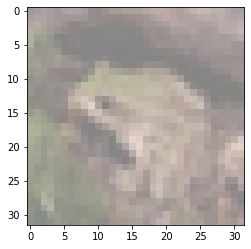

Class frog


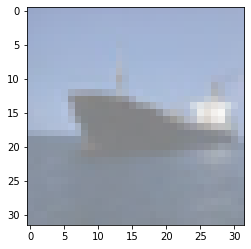

Class ship


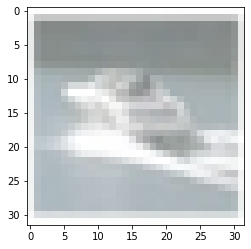

Class ship


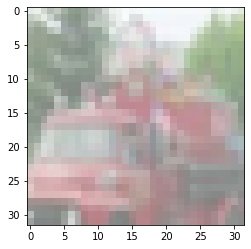

Class truck


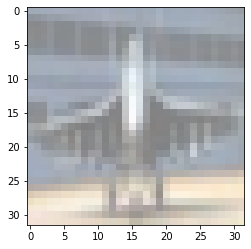

Class plane


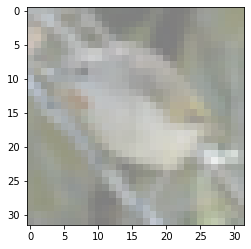

Class bird


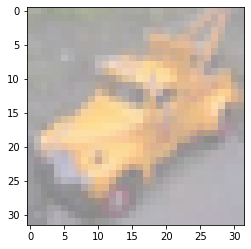

Class truck


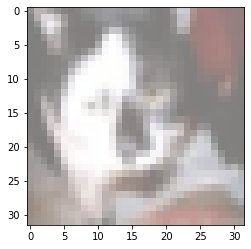

Class cat


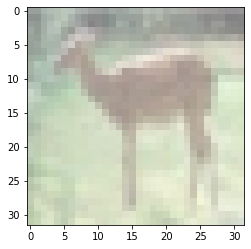

Class deer


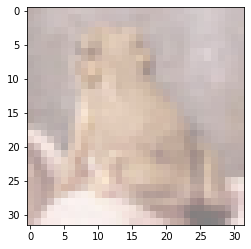

Class frog


In [ ]:
def imshow(img):
  img = img / 2 + 0.5  
  npimg = img.numpy()  
  plt.imshow(np.transpose(npimg, (1, 2, 0))) 
  plt.show()


for i in range(10): 
    imshow(torchvision.utils.make_grid(train_x[i]))
    print(f'Class {classes[train_y[i]]}')

In [ ]:
train_x = torch.Tensor([ mean_colour_channels(image) for image in train_x])
test_x = torch.Tensor([ mean_colour_channels(image) for image in test_x])

In [ ]:
train_x.shape

torch.Size([5000, 32, 32])

Now, we will see the same images when we have got the mean of the colour channels.

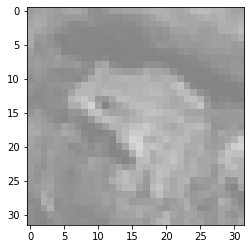

Class frog


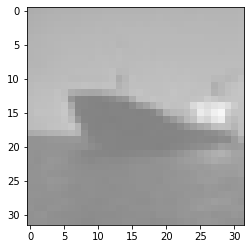

Class ship


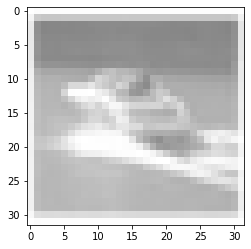

Class ship


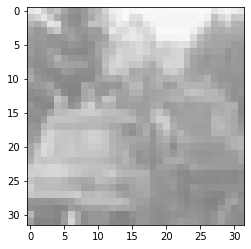

Class truck


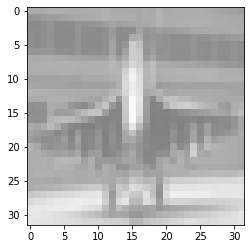

Class plane


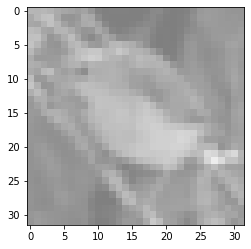

Class bird


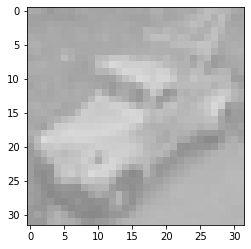

Class truck


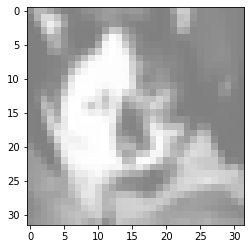

Class cat


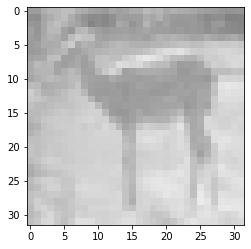

Class deer


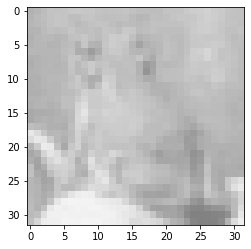

Class frog


In [ ]:
def imshow(img):
  img = img / 2 + 0.5   
  npimg = img.numpy()   
  plt.imshow(np.transpose(npimg, (1, 2, 0))) 
  plt.show()


for i in range(10):
    imshow(torchvision.utils.make_grid(train_x[i]))
    print(f'Class {classes[train_y[i]]}')

In [ ]:
train_x = [torch.flatten(x).numpy() for x in train_x]
test_x = [torch.flatten(x).numpy() for x in test_x]

In [ ]:
def transform_img(images):
    return [torch.flatten(torch.Tensor(mean_colour_channels(image))).numpy() for image in images]

## Models
### Comparing the models

We will tune the parameters for all of our models.

In [ ]:
def print_results(model):
    print("Best parameters set found on train set:")
    print()
    print(model.best_params_)
    print()
    print("Grid scores on train set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.")
    print()
    true_y, pred_y = test_y, model.predict(test_x)
    print(classification_report(true_y, pred_y))
    print()
    

def evaluate_models(models):
    results_short = {}
    for score in scores:
        print('='*40)
        print("# Tuning hyper-parameters for %s" % score)
        print()

        for m in model_lbls:
            print('-'*40)
            print("Trying model {}".format(models[m]['name']))
            clf = GridSearchCV(models[m]['estimator'], models[m]['param'], cv=5,
                               scoring='%s_macro' % score, 
                               return_train_score = False,
                               n_jobs = 2,
                               )
            clf.fit(train_x, train_y)
            print_results(clf)
            results_short[m] = clf.best_score_
        print("Summary of results for {}".format(score))
        print("Estimator")
        for m in results_short.keys():
            print("{}\t - score: {:4.2}%".format(models[m]['name'], results_short[m]))

def plot_scores_by_parameter(model,ks,X_train,X_test,y_train,y_test,visualize=True):
    train_scores = []
    test_scores = []
    
    for k in ks:
        clf = model(k).fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    if visualize:
        plt.figure(figsize=(10, 6))
        plt.plot(ks, train_scores, color='blue', label='train score')
        plt.plot(ks, test_scores, color='green', label='valid score')
        plt.legend()
    return train_scores,test_scores

In [ ]:
lr = LogisticRegression()

In [ ]:
lr.fit(train_x,train_y)

LogisticRegression()

In [ ]:
test_pred=lr.predict(test_x)
test_pred

array([3, 5, 0, 1, 6, 7, 9, 0, 3, 6, 2, 8, 4, 3, 8, 8, 4, 2, 3, 7, 7, 8,
       9, 9, 7, 5, 1, 7, 7, 1, 8, 5, 0, 3, 6, 0, 2, 8, 7, 1, 3, 2, 9, 4,
       5, 1, 6, 6, 5, 9, 3, 9, 8, 2, 0, 3, 9, 6, 1, 4, 1, 6, 5, 4, 4, 9,
       4, 5, 3, 2, 4, 2, 0, 4, 7, 0, 6, 7, 2, 6, 9, 5, 5, 6, 8, 9, 6, 3,
       0, 4, 6, 9, 0, 6, 9, 6, 9, 8, 1, 1, 2, 2, 8, 0, 0, 7, 3, 3, 2, 0,
       1, 8, 9, 2, 6, 5, 5, 6, 0, 4, 6, 2, 7, 7, 3, 7, 6, 9, 5, 0, 7, 2,
       8, 5, 6, 6, 5, 3, 2, 5, 8, 2, 9, 6, 9, 9, 4, 4, 3, 1, 0, 1, 0, 2,
       4, 4, 8, 1, 1, 9, 9, 0, 8, 4, 1, 1, 4, 9, 8, 0, 6, 8, 6, 6, 0, 4,
       5, 9, 9, 6, 9, 4, 1, 9, 3, 3, 0, 0, 8, 6, 7, 9, 9, 5, 6, 5, 2, 3,
       8, 4, 0, 0, 7, 7, 1, 9, 5, 7, 2, 3, 0, 5, 9, 9, 8, 5, 7, 7, 0, 1,
       2, 0, 3, 0, 8, 9, 7, 3, 4, 0, 7, 2, 9, 0, 6, 5, 9, 5, 2, 7, 7, 1,
       8, 6, 0, 9, 6, 4, 6, 4, 2, 1, 0, 1, 2, 1, 4, 4, 5, 1, 9, 8, 8, 1,
       8, 1, 6, 0, 2, 8, 1, 9, 0, 4, 6, 1, 8, 4, 8, 8, 5, 7, 4, 6, 1, 0,
       8, 6, 4, 9, 7, 1, 7, 7, 4, 0, 6, 3, 3, 7, 5,

In [ ]:
print(accuracy_score(test_pred,test_y))
print(classification_report(test_pred,test_y))

0.254
              precision    recall  f1-score   support

           0       0.36      0.31      0.33       108
           1       0.27      0.26      0.26       105
           2       0.12      0.16      0.14        74
           3       0.12      0.16      0.14        89
           4       0.15      0.13      0.14       105
           5       0.24      0.25      0.25        97
           6       0.26      0.21      0.23       115
           7       0.24      0.30      0.27        81
           8       0.39      0.41      0.40       105
           9       0.37      0.31      0.34       121

    accuracy                           0.25      1000
   macro avg       0.25      0.25      0.25      1000
weighted avg       0.26      0.25      0.26      1000



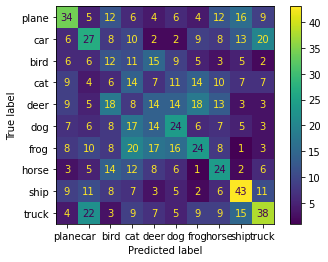

In [ ]:
cm = confusion_matrix(test_pred,test_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot()

#### Naive Bayes

Firstly, we will take a closer look at the Naive Bayes.

- Gaussian Naive Bayes: assumes that the data is normally distributed, and it calculates the mean and standard deviation of each feature in each class. Then, it uses these parameters to calculate the probability of each feature being in a certain class. The probability density function of the normal distribution is used to estimate the likelihood of observing a feature value given the class label. This approach works well for continuous numerical data.

- Multinomial Naive Bayes: calculates the probability of each feature being in a certain class based on the frequency of that feature in the training data. It is commonly used for text classification problems. Each feature is a word or a n-gram of words in the case of text classification. The probabilities are estimated using the maximum likelihood method, which involves counting the occurrences of each word in the training data for each class and normalizing the counts. The final probability is calculated by multiplying the individual probabilities of each word in a given text.

- Bernoulli Naive Bayes: is similar to Multinomial, but it is used for binary data where the features are either present or not. It calculates the probability of a feature being in a certain class based on the presence or absence of the feature in the training data. In this approach, the probabilities are estimated by counting the number of occurrences of each feature in each class and normalizing the counts. The final probability is calculated by multiplying the individual probabilities of each feature in a given data.

- Complement Naive Bayes: is an extension of the Multinomial Naive Bayes that is used to handle imbalanced datasets. It estimates the probability of a class being negative based on the presence of a feature, and the probability of a class being positive based on the absence of a feature. This approach helps in avoiding bias towards the majority class in imbalanced datasets.

In [ ]:
transformer = transforms.Compose([
                               torchvision.transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.Tensor(mean_colour_channels(x))),
    transforms.Lambda(lambda x: torch.flatten(x)),
                             ])

In [ ]:
train_set=torchvision.datasets.CIFAR10('./files/cifar10/', train=True, download=False,
                             transform=transformer)

test_set=torchvision.datasets.CIFAR10('./files/cifar10/', train=False, download=False,
                             transform=transformer)

batch_size_train= (int)(len(train_set)/10)
batch_size_test=  (int)(len(test_set)/10)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=batch_size_test, shuffle=True)

In [ ]:
train_enumerated = enumerate(train_loader)
batch_idx, (train_x, train_y) = next(train_enumerated)

test_enumerated = enumerate(test_loader)
batch_idx, (test_x, test_y) = next(test_enumerated)

In [ ]:
model_lbls = [
              'gnb', 
              'mnb', 
              'cnb', 
              'bnb', 
            ]

models = {
    'gnb': {'name': 'Gaussian Naive Bayes       ',
           'estimator': GaussianNB(), 
           'param': [{}],
          },
    'mnb': {'name': 'Multinomial Naive Bayes       ',
           'estimator': MultinomialNB(),
           'param': [{}]
          },
    'cnb': {'name': 'ComplementNB   ',
           'estimator': ComplementNB(),
           'param': [{}],
          },
    'bnb':{'name': 'BernoulliNB      ',
           'estimator': BernoulliNB(), 
           'param': [{}]
          },
}

scores = ['f1']

In [ ]:
evaluate_models(models)

# Tuning hyper-parameters for f1

----------------------------------------
Trying model Gaussian Naive Bayes       
Best parameters set found on train set:

{}

Grid scores on train set:


Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.20      0.36      0.26       100
           1       0.43      0.09      0.15        97
           2       0.27      0.07      0.11        98
           3       0.25      0.10      0.14       109
           4       0.19      0.49      0.27        84
           5       0.23      0.15      0.18       106
           6       0.24      0.44      0.31       108
           7       0.38      0.09      0.14        90
           8       0.30      0.30      0.30       102
           9       0.39      0.42      0.41       106

    accuracy                           0.25      1000
   macro a

As we can see the Multinomial Naive Bayes and the Gaussian Naive Bayes outperform the other two classifiers.
However, we will see what will happen if we pick the right parameters for each of the models.

In [ ]:
models = {
    'mnb': {'name': 'Multinomial Naive Bayes       ',
           'estimator': MultinomialNB(),
           'param': [{'alpha': [0,0.1,0.3,0.5,0.75,1,2,3,4,10,20,30,50,100],}]
          },
    'bnb':{'name': 'BernoulliNB      ',
           'estimator': BernoulliNB(), 
           'param': [{'alpha': [0,0.1,0.3,0.5,0.75,1,2,3,4,10,20,30,50,100],

'binarize' :[ None,0,0.1,0.3,0.5,0.75,1,2,3,4,10,20,30,50,100],
}]
          },
        'cnb': {'name': 'ComplementNB   ',
           'estimator': ComplementNB(),
           'param': [{'norm':[True,False],'alpha': [0,0.1,0.3,0.5,0.75,1,2,3,4,10,20,30,50,100]}],
          },
        'gnb': {'name': 'Gaussian Naive Bayes       ',
           'estimator': GaussianNB(), 
           'param': [{'var_smoothing': np.logspace(0,-9, num=100)}],
          },
}

In [ ]:
evaluate_models(models)

# Tuning hyper-parameters for f1

----------------------------------------
Trying model Gaussian Naive Bayes       
Best parameters set found on train set:

{'var_smoothing': 0.0015199110829529332}

Grid scores on train set:


Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.20      0.36      0.26       100
           1       0.43      0.09      0.15        97
           2       0.27      0.07      0.11        98
           3       0.26      0.10      0.14       109
           4       0.19      0.49      0.27        84
           5       0.23      0.15      0.18       106
           6       0.24      0.44      0.31       108
           7       0.38      0.09      0.14        90
           8       0.30      0.30      0.30       102
           9       0.39      0.42      0.41       106

    accuracy              

##### Tuning the best models

We will try to make a better decision about the parameters of our models.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, random_state=0)

###### Multinomial Naive Bayes

In [ ]:
mnb_constructor = lambda a: MultinomialNB(alpha=a)

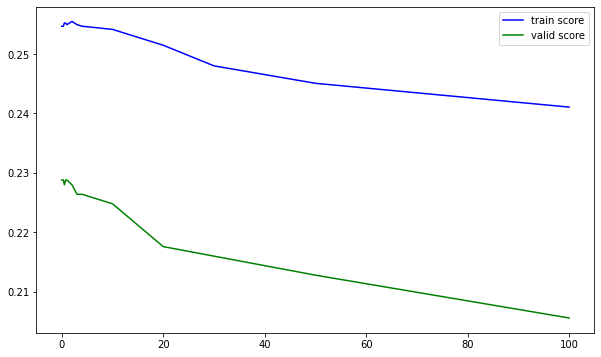

In [ ]:
_=plot_scores_by_parameter(mnb_constructor,[0,0.1,0.3,0.5,0.75,1,2,3,4,10,20,30,50,100],X_train,X_valid,y_train,y_valid)

The best results are between 0 and 1. So we will try the experiment again with smaller numbers.

([0.25466666666666665,
  0.25466666666666665,
  0.25466666666666665,
  0.25466666666666665,
  0.25466666666666665,
  0.25466666666666665,
  0.25466666666666665,
  0.2552,
  0.2552,
  0.2552,
  0.2552,
  0.2552,
  0.2552,
  0.2552,
  0.2552,
  0.2552,
  0.2552,
  0.25493333333333335,
  0.25493333333333335,
  0.25493333333333335,
  0.25493333333333335,
  0.2552,
  0.2552,
  0.2552,
  0.2552,
  0.2552,
  0.2552,
  0.2552,
  0.2552,
  0.2552,
  0.25493333333333335,
  0.25493333333333335,
  0.2552,
  0.2552,
  0.2554666666666667,
  0.2554666666666667,
  0.2554666666666667,
  0.2554666666666667,
  0.2557333333333333,
  0.2557333333333333],
 [0.2288,
  0.2288,
  0.2288,
  0.2288,
  0.2288,
  0.2288,
  0.2288,
  0.228,
  0.228,
  0.228,
  0.228,
  0.228,
  0.228,
  0.228,
  0.2288,
  0.2288,
  0.2288,
  0.2288,
  0.2288,
  0.2288,
  0.2288,
  0.2288,
  0.2288,
  0.2288,
  0.2288,
  0.2288,
  0.2288,
  0.2288,
  0.2288,
  0.228,
  0.228,
  0.228,
  0.228,
  0.228,
  0.228,
  0.228,
  0.228,
  0

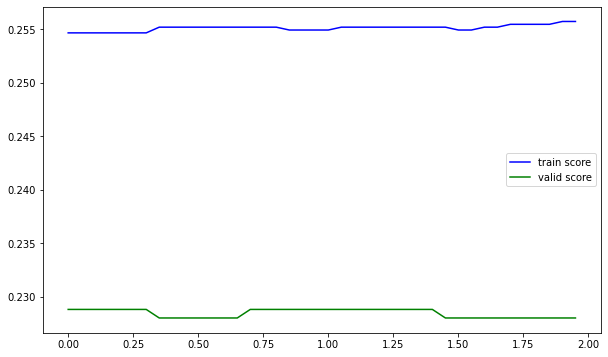

In [ ]:
plot_scores_by_parameter(mnb_constructor,np.arange(0,2,0.05),X_train,X_valid,y_train,y_valid)

The experiment confirms the previous results and we will use aplha=0.

###### Bernoulli Naive Bayes

Now we will do the same for BernoulliNB. From the previous experiments with the parameters we now that alpha must be around 10
and binarize must be None.

In [ ]:
bnb_by_alpha_constructor = lambda a: BernoulliNB(alpha=a,binarize=None)
bnb_by_binarize_constructor = lambda b: BernoulliNB(alpha=10,binarize=b)

([0.25866666666666666,
  0.25893333333333335,
  0.25893333333333335,
  0.25866666666666666,
  0.25893333333333335,
  0.25866666666666666,
  0.25866666666666666,
  0.2584,
  0.2581333333333333,
  0.2581333333333333,
  0.2584,
  0.2584,
  0.2581333333333333,
  0.2576,
  0.25706666666666667,
  0.25706666666666667,
  0.25653333333333334,
  0.25733333333333336,
  0.2568,
  0.25733333333333336],
 [0.2168,
  0.2168,
  0.2176,
  0.2168,
  0.216,
  0.2168,
  0.2184,
  0.2208,
  0.2208,
  0.22,
  0.22,
  0.22,
  0.2208,
  0.2192,
  0.2184,
  0.2184,
  0.2184,
  0.2192,
  0.2184,
  0.2192])

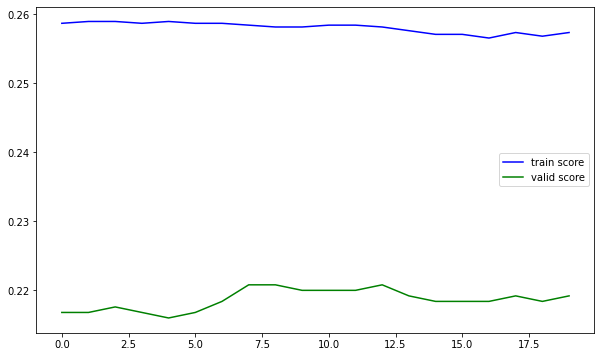

In [ ]:
plot_scores_by_parameter(bnb_by_alpha_constructor,np.arange(0,20,1),X_train,X_valid,y_train,y_valid)

([0.2584,
  0.25866666666666666,
  0.2581333333333333,
  0.2581333333333333,
  0.2581333333333333,
  0.25866666666666666,
  0.2584,
  0.2584,
  0.2584,
  0.2584,
  0.2581333333333333,
  0.2576,
  0.2576,
  0.25733333333333336],
 [0.2208,
  0.2208,
  0.2208,
  0.22,
  0.22,
  0.22,
  0.22,
  0.22,
  0.22,
  0.22,
  0.2208,
  0.2208,
  0.2192,
  0.2184])

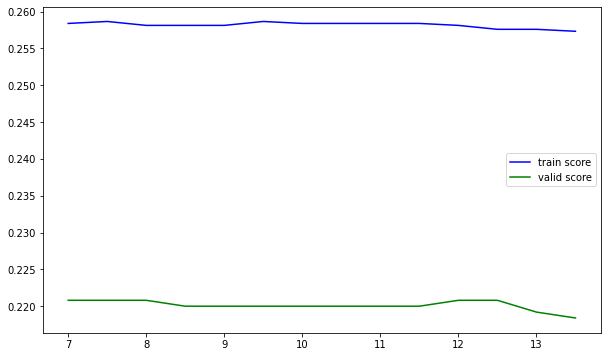

In [ ]:
plot_scores_by_parameter(bnb_by_alpha_constructor,np.arange(7,14,0.5),X_train,X_valid,y_train,y_valid)

As we can see the best value for alpha is 12.

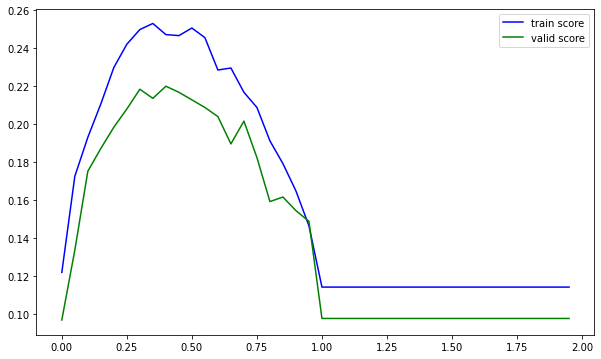

In [ ]:
_=plot_scores_by_parameter(bnb_by_binarize_constructor,np.arange(0,2,0.05),X_train,X_valid,y_train,y_valid)

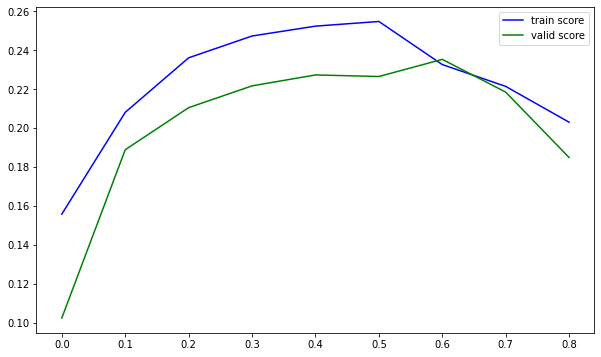

In [ ]:
_=plot_scores_by_parameter(bnb_by_binarize_constructor,np.arange(0,0.9,0.1),X_train,X_valid,y_train,y_valid)

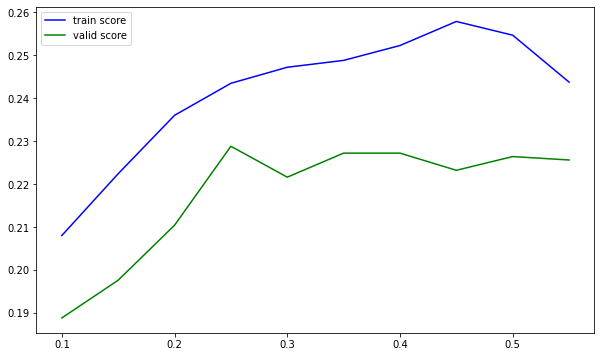

In [ ]:
_=plot_scores_by_parameter(bnb_by_binarize_constructor,np.arange(0.1,0.6,0.05),X_train,X_valid,y_train,y_valid)

The best value for binarize is around 0.4.
Now we will try the model with values for alpha and binarize which are close to teh already found ones.

In [ ]:
bnb_models=[]
bnb_models.append(BernoulliNB(alpha=10,binarize=None))
bnb_models.append(BernoulliNB(alpha=10,binarize=0.4))
bnb_models.append(BernoulliNB(alpha=12,binarize=None))
bnb_models.append(BernoulliNB(alpha=12,binarize=0.4))

In [ ]:
for i,model in enumerate(bnb_models):
    model.fit(X_train, y_train)
    print(f'Model {i} score: {model.score(X_valid, y_valid)}')

Model 0 score: 0.22
Model 1 score: 0.22
Model 2 score: 0.2208
Model 3 score: 0.2216


This experiment confirms our previoues results. The best values are alpha=12, binarize=0.4

###### Gaussian Naive Bayes
var_smoothing should be around 0.0015199110829529332.

In [ ]:
gnb_constructor = lambda a: GaussianNB(var_smoothing=a)

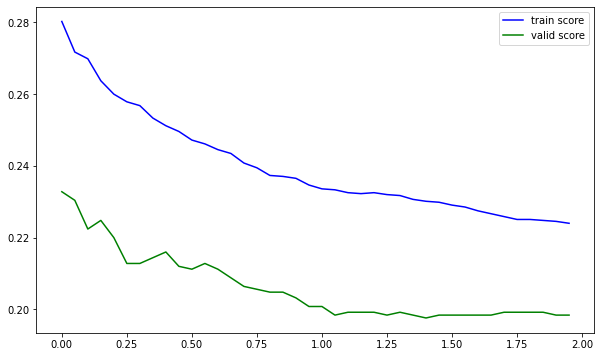

In [ ]:
_=plot_scores_by_parameter(gnb_constructor,np.arange(0,2,0.05),X_train,X_valid,y_train,y_valid)

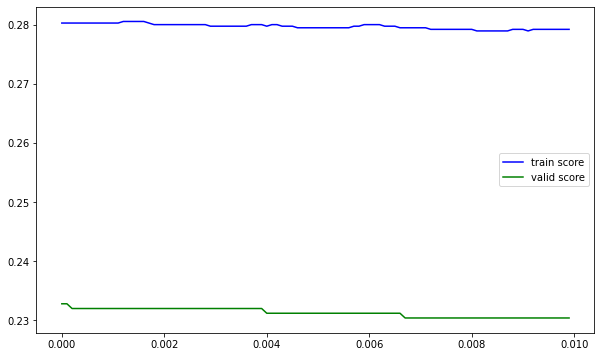

In [ ]:
_=plot_scores_by_parameter(gnb_constructor,np.arange(0,0.01,0.0001),X_train,X_valid,y_train,y_valid)

Best value for var_smoothing is 0.

##### Comparing the Naive Bayes models
Let's test our tuned models on the test data.

In [ ]:
bnb = BernoulliNB(alpha=12,binarize=0.4)
gnb = GaussianNB(var_smoothing=0)
mnb = MultinomialNB(alpha=0)

_, (train_x, train_y) = next(train_enumerated)
_, (test_x, test_y) = next(test_enumerated)

bnb.fit(train_x,train_y)
gnb.fit(train_x,train_y)
mnb.fit(train_x,train_y)

MultinomialNB(alpha=0)

In [ ]:
print(f'BernoulliNB F1 score on train data is {f1_score(train_y,bnb.predict(train_x),average="micro")}')
print(f'BernoulliNB F1 score on test data is {f1_score(test_y,bnb.predict(test_x),average="micro")}')
print(f'GaussianNB Tree F1 score on train data is {f1_score(train_y,gnb.predict(train_x),average="micro")}')
print(f'GaussianNB Tree F1 score on test data is {f1_score(test_y,gnb.predict(test_x),average="micro")}')
print(f'MultinomialNB Tree F1 score on train data is {f1_score(train_y,mnb.predict(train_x),average="micro")}')
print(f'MultinomialNB Tree F1 score on test data is {f1_score(test_y,mnb.predict(test_x),average="micro")}')

BernoulliNB F1 score on train data is 0.2482
BernoulliNB F1 score on test data is 0.245
GaussianNB Tree F1 score on train data is 0.2702
GaussianNB Tree F1 score on test data is 0.265
MultinomialNB Tree F1 score on train data is 0.2442
MultinomialNB Tree F1 score on test data is 0.239


GaussianNB is the best classifier for this dataset.

#### SVM, Logistic Regression, Gaussian NB and Decision Tree Classifier

In [ ]:
transformer = transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])

In [ ]:
train_set=torchvision.datasets.CIFAR10('./files/cifar10/', train=True, download=False,
                             transform=transformer)

test_set=torchvision.datasets.CIFAR10('./files/cifar10/', train=False, download=False,
                             transform=transformer)

batch_size_train= (int)(len(train_set)/10)
batch_size_test=(int)(len(test_set)/10)


In [ ]:
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=batch_size_test, shuffle=True)

In [ ]:
train_enumerated = enumerate(train_loader)
batch_idx, (train_x, train_y) = next(train_enumerated)

test_enumerated = enumerate(test_loader)
batch_idx, (test_x, test_y) = next(test_enumerated)

In [ ]:
train_x = transform_img(train_x)
test_x = transform_img(test_x)

NuSVC and SVC are two algorithms which belong to the Support Vector Machine (SVM) family of algorithms, which are used to find the boundary that separates the data into classes.

The main difference between NuSVC and SVC is the method used to find the boundary that separates the data.

SVC is a traditional SVM algorithm that uses the maximum margin principle to find the boundary between the classes. The algorithm finds the boundary that maximizes the margin between the classes, meaning the distance between the closest data points from different classes.

Whereas NuSVC uses the parameter nu to control the trade-off between the number of misclassified points and the size of the margin. NuSVC is more flexible than SVC because it allows for non-linearly separable data and is less sensitive to the choice of kernel function. The value of nu is between 0 and 1, and it determines the percentage of training data that is allowed to be misclassified.

In [ ]:
models = { 
    'svc': {'name': 'SVC',
           'estimator': SVC(),
           'param': [{'C':[0.1,0.25,0.5,0.8,1,2,3,5,10,20,50],'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'random_state':[1]}]
          },
    'nsvc':{'name': 'NuSVC',
           'estimator': NuSVC(), 
           'param': [{'nu':[0.05,0.1,0.2,0.4,0.5,0.7,0.9,1],'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'random_state':[1]}]
        },
}

model_lbls = ['svc','nsvc']
scores = ['f1']

In [ ]:
evaluate_models(models)

# Tuning hyper-parameters for f1

----------------------------------------
Trying model SVC
Best parameters set found on train set:

{'C': 2, 'kernel': 'rbf', 'random_state': 1}

Grid scores on train set:


Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.48      0.39      0.43        99
           1       0.39      0.38      0.38        74
           2       0.29      0.28      0.28       114
           3       0.25      0.24      0.25        96
           4       0.33      0.39      0.36       114
           5       0.32      0.21      0.25        92
           6       0.38      0.45      0.41       120
           7       0.45      0.40      0.42       103
           8       0.48      0.58      0.53        98
           9       0.45      0.50      0.47        90

    accuracy                           0.38   

In [ ]:
 models = {  'dt':{'name': 'DecisionTreeClassifier',
           'estimator': DecisionTreeClassifier(), 
           'param': [{'criterion':['gini', 'entropy', 'log_loss'],
'splitter':['best', 'random'],'max_features':['auto', 'sqrt', 'log2'],'random_state':[1]}]
        },
        'lr':{'name': 'LogisticRegression',
           'estimator': LogisticRegression(), 
           'param': [{'C':[0.5,1,2,5,10,20,50],'penalty':['l1', 'l2','elasticnet',None],
'dual':[True,False],'random_state':[1]}]
        },
        'gn':{'name':'GaussianNB',
              'estimator':GaussianNB(),
              'param':[{'var_smoothing':[0]}]}
        }
    
model_lbls = ['lr','dt','gn']

In [ ]:
evaluate_models(models)

# Tuning hyper-parameters for f1

----------------------------------------
Trying model LogisticRegression
Best parameters set found on train set:

{'C': 0.5, 'dual': False, 'penalty': 'l2', 'random_state': 1}

Grid scores on train set:


Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.35      0.34      0.35        99
           1       0.20      0.23      0.21        74
           2       0.19      0.20      0.19       114
           3       0.18      0.17      0.17        96
           4       0.13      0.10      0.11       114
           5       0.16      0.17      0.17        92
           6       0.23      0.19      0.21       120
           7       0.13      0.13      0.13       103
           8       0.27      0.34      0.30        98
           9       0.32      0.34      0.33        90

    accuracy  

The best model is SVC. Its results are pretty close to the results of the NuSVC. However, the algorithms are also similar. So we will pick one of them.

### Tuning the models

We will try to make a better decision about our parameters of the models and will want to improve the f1 score.

In [ ]:
_, (train_b_x, train_b_y) = next(train_enumerated)
_, (test_b_x, valid_b_y) = next(test_enumerated)
train_b_x = transform_img(train_b_x)
test_b_x = transform_img(test_b_x)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_b_x, train_y, random_state=0)

#### SVC

In [ ]:
svc_constructor = lambda a: SVC(C=a, kernel='rbf', random_state=1)

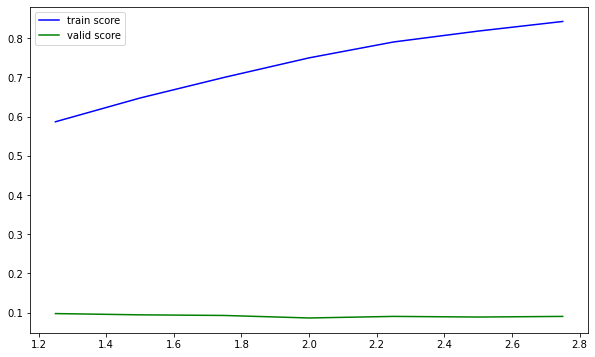

In [ ]:
_=plot_scores_by_parameter(svc_constructor,[1.25,1.5,1.75,2,2.25,2.5,2.75], X_train, X_valid, y_train, y_valid)

The best train score are above 2.5. So we will try the experiment again with bigger numbers.

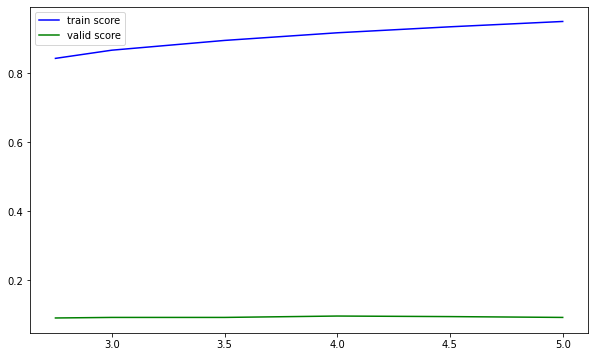

In [ ]:
_=plot_scores_by_parameter(svc_constructor,[2.75,3,3.5,4,4.5,5], X_train, X_valid, y_train, y_valid)

As we can see the test score does not improve. That means that the model overfits. So we will stop and use 2 as C.

####  LogisticRegression

Now we will do the same for LogisticRegression. We know that C must be around 0.5.

In [ ]:
lr_constructor = lambda a: LogisticRegression(C=a, dual=False, penalty='l2', random_state=1)

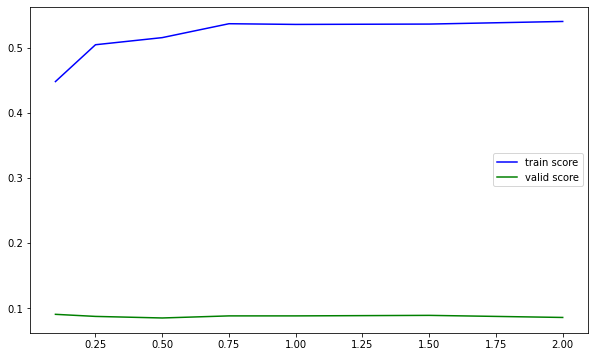

In [ ]:
_=plot_scores_by_parameter(lr_constructor,[0.1,0.25,0.5,0.75,1,1.5,2], X_train, X_valid, y_train, y_valid)

The test score only decreases. So we will use 0.1. 

#### DecisionTreeClassifier

We know that these are the best parameters. Now we will tune the max_depth param.
{'criterion': 'entropy', 'max_features': 'auto', 'random_state': 1, 'splitter': 'best'}

In [ ]:
dt_constructor = lambda a: DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best',max_depth=a)

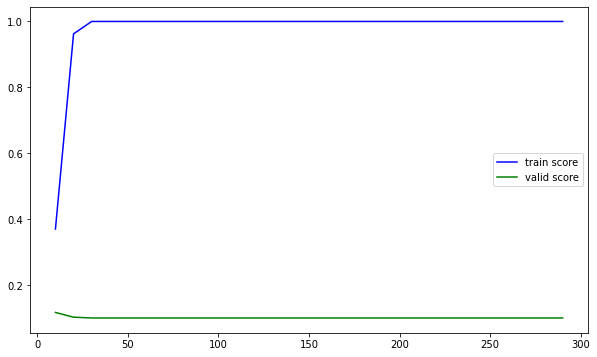

In [ ]:
_=plot_scores_by_parameter(dt_constructor,range(10,300,10), X_train, X_valid, y_train, y_valid)

After 30 it starts to overfit. Let's see what happens between 0 and 30.

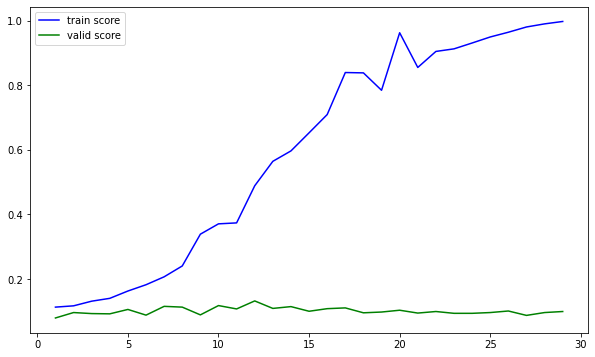

In [ ]:
_=plot_scores_by_parameter(dt_constructor,range(1,30,1), X_train, X_valid, y_train, y_valid)

The best validation score is on 6.

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best',max_depth=6)
dt_no_max_depth = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best')

dt.fit(X_train,  y_train)
print(f'Validation score with max_depth=6: {dt.score(X_valid, y_valid)}')

dt_no_max_depth.fit(train_b_x,  train_b_y)
print(f'Validation score with max_depth=None: {dt_no_max_depth.score(X_valid, y_valid)}')

Validation score with max_depth=6: 0.088
Validation score with max_depth=None: 0.1128


We will use `max_depth=None`.

### Testing the models

In [ ]:
_, (train_b_x, train_b_y) = next(train_enumerated)
_, (test_b_x, test_b_y) = next(test_enumerated)
train_b_x = transform_img(train_b_x)
test_b_x = transform_img(test_b_x)

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best',max_depth=None)
lr = LogisticRegression(C=0.1, dual=False, penalty='l2', random_state=1)
svc = SVC(C=2, kernel='rbf', random_state=1)
gnb = GaussianNB(var_smoothing=0)

In [ ]:
dt.fit(train_b_x,train_b_y)
lr.fit(train_b_x,train_b_y)
svc.fit(train_b_x,train_b_y)
gnb.fit(train_b_x,train_b_y)

GaussianNB(var_smoothing=0)

In [ ]:
print(f'Decision Tree F1 score on train data is {f1_score(train_b_y,dt.predict(train_b_x),average="micro")}')
print(f'Logistic Regression F1 score on train data is {f1_score(train_b_y,lr.predict(train_b_x),average="micro")}')
print(f'SVC F1 score on train data is {f1_score(train_b_y,svc.predict(train_b_x),average="micro")}')
print(f'GaussianNB F1 score on train data is {f1_score(train_b_y,gnb.predict(train_b_x),average="micro")}')

Decision Tree F1 score on train data is 1.0
Logistic Regression F1 score on train data is 0.4288
SVC F1 score on train data is 0.8048
GaussianNB F1 score on train data is 0.2702


In [ ]:
print(f'Decision Tree F1 score on test data is {f1_score(test_b_y,dt.predict(test_b_x),average="micro")}')
print(f'Logistic Regression F1 score on test data is {f1_score(test_b_y,lr.predict(test_b_x),average="micro")}')
print(f'SVC F1 score on test data is {f1_score(test_b_y,svc.predict(test_b_x),average="micro")}')
print(f'GaussianNB F1 score on test data is {f1_score(test_b_y,gnb.predict(test_b_x),average="micro")}')

Decision Tree F1 score on test data is 0.167
Logistic Regression F1 score on test data is 0.283
SVC F1 score on test data is 0.38499999999999995
GaussianNB F1 score on test data is 0.285


## Feature extraction

We have our models tuned. Now we will try different approaches for feature extraction.

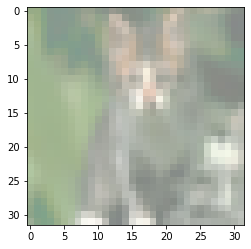

Class cat


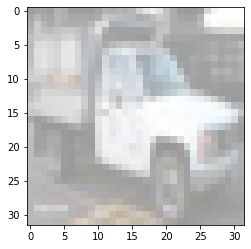

Class truck


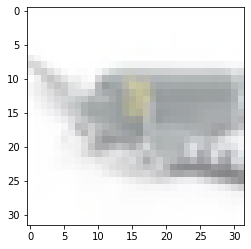

Class plane


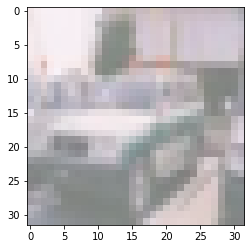

Class car


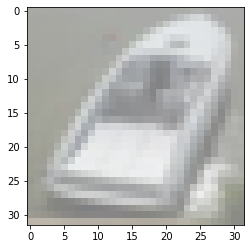

Class ship


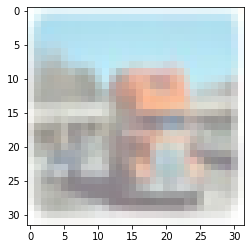

Class truck


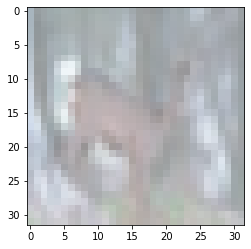

Class deer


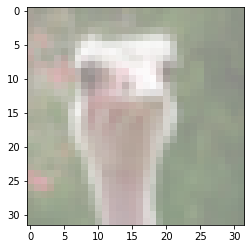

Class bird


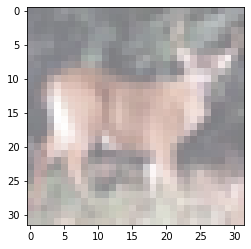

Class deer


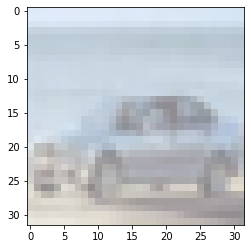

Class car


In [ ]:
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=batch_size_test, shuffle=True)
train_enumerated = enumerate(train_loader)
batch_idx, (train_x, train_y) = next(train_enumerated)

test_enumerated = enumerate(test_loader)
batch_idx, (test_x, test_y) = next(test_enumerated)
train_x.shape
train_x[1].shape

def imshow(img,convert=True):
    img = img / 2 + 0.5 
    if convert:
        img = img.numpy()   
    plt.imshow(np.transpose(img, (1, 2, 0))) 
    plt.show()

def print_white_black_image(img):
    fig = plt.figure
    plt.imshow(img, cmap='gray')
    plt.show()


for i in range(10):
    imshow(torchvision.utils.make_grid(train_x[i]))
    print(f'Class {classes[train_y[i]]}')

In [ ]:
def gray_scale_img(image):
    feature_matrix = np.zeros((32,32))
    for i in range(0,32):
        for j in range(0,32):
            feature_matrix[i][j] = 0.2126 * image[0,i,j] + 0.7152 * image[1,i,j] + 0.0722 * image[2,i,j]
    return feature_matrix  

In [ ]:
def mean_colour_channels(image):
    feature_matrix = np.zeros((32,32))
    for i in range(0,32):
        for j in range(0,32):
            feature_matrix[i][j] = ((image[0,i,j] + image[1,i,j] + image[2,i,j])/3)
    return feature_matrix  

### Mean Colour Channels vs Making a photo gray scale using weights

#### Gray scale image using weights
The weights are based on how the human eye perceives color.

In [ ]:
gr_train_x = [gray_scale_img(img) for img in train_x]
gr_test_x = [gray_scale_img(img) for img in test_x]

In [ ]:
gr_train_x = [torch.flatten(torch.from_numpy(x)).numpy() for x in gr_train_x]
gr_test_x = [torch.flatten(torch.from_numpy(x)).numpy() for x in gr_test_x]

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best',max_depth=None)
lr = LogisticRegression(C=0.1, dual=False, penalty='l2', random_state=1)
svc = SVC(C=2, kernel='rbf', random_state=1)
gnb = GaussianNB(var_smoothing=0)

In [ ]:
dt.fit(gr_train_x,train_y)
lr.fit(gr_train_x,train_y)
svc.fit(gr_train_x,train_y)
gnb.fit(gr_train_x,train_y)

GaussianNB(var_smoothing=0)

In [ ]:
print(f'Decision Tree F1 score on train data is {f1_score(train_y,dt.predict(gr_train_x),average="micro")}')
print(f'Logistic Regression F1 score on train data is {f1_score(train_y,lr.predict(gr_train_x),average="micro")}')
print(f'SVC F1 score on train data is {f1_score(train_y,svc.predict(gr_train_x),average="micro")}')
print(f'GaussianNB F1 score on train data is {f1_score(train_y,gnb.predict(gr_train_x),average="micro")}')

Decision Tree F1 score on train data is 1.0
Logistic Regression F1 score on train data is 0.4126
SVC F1 score on train data is 0.7994
GaussianNB F1 score on train data is 0.2638


In [ ]:
print(f'Decision Tree F1 score on test data is {f1_score(test_y,dt.predict(gr_test_x),average="micro")}')
print(f'Logistic Regression F1 score on test data is {f1_score(test_y,lr.predict(gr_test_x),average="micro")}')
print(f'SVC F1 score on test data is {f1_score(test_y,svc.predict(gr_test_x),average="micro")}')
print(f'GaussianNB F1 score on test data is {f1_score(test_y,gnb.predict(gr_test_x),average="micro")}')

Decision Tree F1 score on test data is 0.165
Logistic Regression F1 score on test data is 0.249
SVC F1 score on test data is 0.36499999999999994
GaussianNB F1 score on test data is 0.256


In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best',max_depth=None)
lr = LogisticRegression(C=0.1, dual=False, penalty='l2', random_state=1)
svc = SVC(C=2, kernel='rbf', random_state=1)
gnb = GaussianNB(var_smoothing=0)

clf = StackingClassifier(estimators=[('dt', dt), ('svc', svc), ('gnb', gnb), ('lr', lr)], final_estimator=LogisticRegression(random_state=0))

clf.fit(gr_train_x, train_y)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_features='auto',
                                                       random_state=1)),
                               ('svc', SVC(C=2, random_state=1)),
                               ('gnb', GaussianNB(var_smoothing=0)),
                               ('lr',
                                LogisticRegression(C=0.1, random_state=1))],
                   final_estimator=LogisticRegression(random_state=0))

In [ ]:
print(f'Stacked models F1 score on train data is {f1_score(train_y,clf.predict(gr_train_x),average="micro")}')

Stacked models F1 score on train data is 0.6162


In [ ]:
print(f'Stacked models F1 score on test data is {f1_score(test_y,clf.predict(gr_test_x),average="micro")}')

Stacked models F1 score on test data is 0.329


The stacked model does not imporve the results of the other models. However, we will use it as a reference for testing the different ways to extract the features.

#### Mean colour

In [ ]:
mc_train_x = [mean_colour_channels(img) for img in train_x]
mc_test_x = [mean_colour_channels(img) for img in test_x]

In [ ]:
mc_train_x = [torch.flatten(torch.from_numpy(x)).numpy() for x in mc_train_x]
mc_test_x = [torch.flatten(torch.from_numpy(x)).numpy() for x in mc_test_x]

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best',max_depth=None)
lr = LogisticRegression(C=0.1, dual=False, penalty='l2', random_state=1)
svc = SVC(C=2, kernel='rbf', random_state=1)
gnb = GaussianNB(var_smoothing=0)

In [ ]:
dt.fit(mc_train_x,train_y)
lr.fit(mc_train_x,train_y)
svc.fit(mc_train_x,train_y)
gnb.fit(mc_train_x,train_y)

GaussianNB(var_smoothing=0)

In [ ]:
print(f'Decision Tree F1 score on train data is {f1_score(train_y,dt.predict(mc_train_x),average="micro")}')
print(f'Logistic Regression F1 score on train data is {f1_score(train_y,lr.predict(mc_train_x),average="micro")}')
print(f'SVC F1 score on train data is {f1_score(train_y,svc.predict(mc_train_x),average="micro")}')
print(f'GaussianNB F1 score on train data is {f1_score(train_y,gnb.predict(mc_train_x),average="micro")}')

Decision Tree F1 score on train data is 1.0
Logistic Regression F1 score on train data is 0.40599999999999997
SVC F1 score on train data is 0.7968
GaussianNB F1 score on train data is 0.2592


In [ ]:
print(f'Decision Tree F1 score on test data is {f1_score(test_y,dt.predict(mc_test_x),average="micro")}')
print(f'Logistic Regression F1 score on test data is {f1_score(test_y,lr.predict(mc_test_x),average="micro")}')
print(f'SVC F1 score on test data is {f1_score(test_y,svc.predict(mc_test_x),average="micro")}')
print(f'GaussianNB F1 score on test data is {f1_score(test_y,gnb.predict(mc_test_x),average="micro")}')

Decision Tree F1 score on test data is 0.17900000000000002
Logistic Regression F1 score on test data is 0.261
SVC F1 score on test data is 0.36499999999999994
GaussianNB F1 score on test data is 0.247


The results after mean colour channels are a little bit better than using weights. That is why we will use `mean_colour_channels` for future experiments.


## Edge detection

We will use edge detecting filters.

### Sobel filter

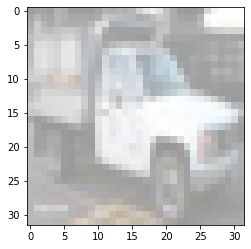

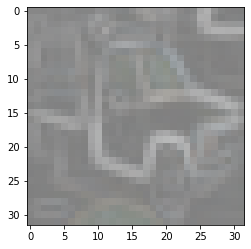

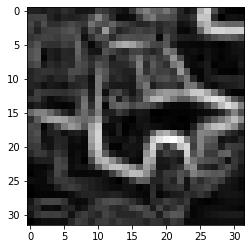

(3, 32, 32)

In [ ]:
sobel_im = sobel(train_x[1])
imshow(train_x[1])
imshow(sobel_im,False)
print_white_black_image(mean_colour_channels(sobel_im))
sobel_im.shape

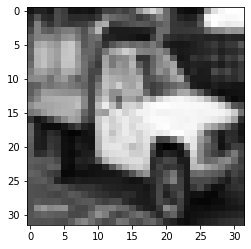

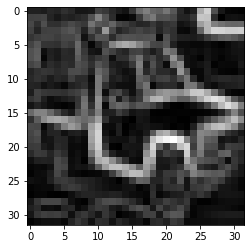

(32, 32)

In [ ]:
img = mean_colour_channels(train_x[1])
sobel_im = sobel(img)
print_white_black_image(img)
print_white_black_image(sobel_im)
sobel_im.shape

### Laplace filter

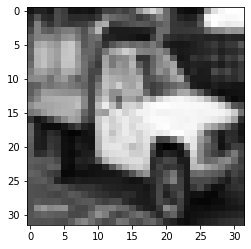

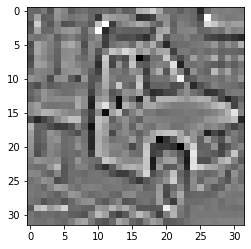

In [ ]:
img = mean_colour_channels(train_x[1])
laplace_im = laplace(img)
print_white_black_image(img)
print_white_black_image(laplace_im)

### Prewitt filter

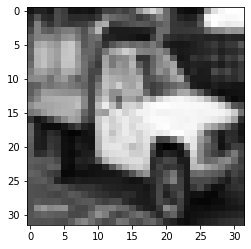

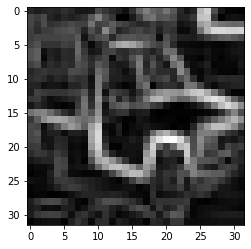

In [ ]:
img = mean_colour_channels(train_x[1])
prewitt_im = prewitt(img)
print_white_black_image(img)
print_white_black_image(prewitt_im)

The result of the laplace filter is not so clear. That is why we will leave it. The results of the prewitt and the sobel filters are really close. However, we will use the sobel filter.

We can also see that using mean_colour_channels and then the filter is better than vice versa. But we will test this hypothesis too.

#### Testing the models with the edge detection filters

In [ ]:
def apply_sobel_after_mean_color(img):
  return torch.flatten(torch.Tensor(sobel(mean_colour_channels(img)))).numpy()
def apply_mean_color_after_sobel(img):
  return torch.flatten(torch.Tensor(mean_colour_channels(sobel(img)))).numpy()

In [ ]:
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=batch_size_test, shuffle=True)
train_enumerated = enumerate(train_loader)
batch_idx, (train_x, train_y) = next(train_enumerated)

test_enumerated = enumerate(test_loader)
batch_idx, (test_x, test_y) = next(test_enumerated)

##### Mean color channels and then Sobel filter

In [ ]:
sobel_after_mcc_train_x = [apply_sobel_after_mean_color(img) for img in train_x]
sobel_after_mcc_test_x = [apply_sobel_after_mean_color(img) for img in test_x]

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best',max_depth=None)
lr = LogisticRegression(C=0.1, dual=False, penalty='l2', random_state=1)
svc = SVC(C=2, kernel='rbf', random_state=1)
gnb = GaussianNB(var_smoothing=0)

In [ ]:
dt.fit(sobel_after_mcc_train_x,train_y)
lr.fit(sobel_after_mcc_train_x,train_y)
svc.fit(sobel_after_mcc_train_x,train_y)
gnb.fit(sobel_after_mcc_train_x,train_y)

GaussianNB(var_smoothing=0)

In [ ]:
print(f'Decision Tree F1 score on train data is {f1_score(train_y,dt.predict(sobel_after_mcc_train_x),average="micro")}')
print(f'Logistic Regression F1 score on train data is {f1_score(train_y,lr.predict(sobel_after_mcc_train_x),average="micro")}')
print(f'SVC F1 score on train data is {f1_score(train_y,svc.predict(sobel_after_mcc_train_x),average="micro")}')
print(f'GaussianNB F1 score on train data is {f1_score(train_y,gnb.predict(sobel_after_mcc_train_x),average="micro")}')

Decision Tree F1 score on train data is 1.0
Logistic Regression F1 score on train data is 0.4464
SVC F1 score on train data is 0.9196
GaussianNB F1 score on train data is 0.3126


In [ ]:
print(f'Decision Tree F1 score on test data is {f1_score(test_y,dt.predict(sobel_after_mcc_test_x),average="micro")}')
print(f'Logistic Regression F1 score on test data is {f1_score(test_y,lr.predict(sobel_after_mcc_test_x),average="micro")}')
print(f'SVC F1 score on test data is {f1_score(test_y,svc.predict(sobel_after_mcc_test_x),average="micro")}')
print(f'GaussianNB F1 score on test data is {f1_score(test_y,gnb.predict(sobel_after_mcc_test_x),average="micro")}')

Decision Tree F1 score on test data is 0.177
Logistic Regression F1 score on test data is 0.298
SVC F1 score on test data is 0.353
GaussianNB F1 score on test data is 0.269


##### Sobel filter and then Mean color channels

In [ ]:
mcc_after_sobel_train_x = [apply_mean_color_after_sobel(img) for img in train_x]
mcc_after_sobel_test_x = [apply_mean_color_after_sobel(img) for img in test_x]

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best',max_depth=None)
lr = LogisticRegression(C=0.1, dual=False, penalty='l2', random_state=1)
svc = SVC(C=2, kernel='rbf', random_state=1)
gnb = GaussianNB(var_smoothing=0)

In [ ]:
dt.fit(mcc_after_sobel_train_x,train_y)
lr.fit(mcc_after_sobel_train_x,train_y)
svc.fit(mcc_after_sobel_train_x,train_y)
gnb.fit(mcc_after_sobel_train_x,train_y)

GaussianNB(var_smoothing=0)

In [ ]:
print(f'Decision Tree F1 score on train data is {f1_score(train_y,dt.predict(mcc_after_sobel_train_x),average="micro")}')
print(f'Logistic Regression F1 score on train data is {f1_score(train_y,lr.predict(mcc_after_sobel_train_x),average="micro")}')
print(f'SVC F1 score on train data is {f1_score(train_y,svc.predict(mcc_after_sobel_train_x),average="micro")}')
print(f'GaussianNB F1 score on train data is {f1_score(train_y,gnb.predict(mcc_after_sobel_train_x),average="micro")}')

Decision Tree F1 score on train data is 1.0
Logistic Regression F1 score on train data is 0.3678
SVC F1 score on train data is 0.8936
GaussianNB F1 score on train data is 0.2546


In [ ]:
print(f'Decision Tree F1 score on test data is {f1_score(test_y,dt.predict(mcc_after_sobel_test_x),average="micro")}')
print(f'Logistic Regression F1 score on test data is {f1_score(test_y,lr.predict(mcc_after_sobel_test_x),average="micro")}')
print(f'SVC F1 score on test data is {f1_score(test_y,svc.predict(mcc_after_sobel_test_x),average="micro")}')
print(f'GaussianNB F1 score on test data is {f1_score(test_y,gnb.predict(mcc_after_sobel_test_x),average="micro")}')

Decision Tree F1 score on test data is 0.151
Logistic Regression F1 score on test data is 0.235
SVC F1 score on test data is 0.284
GaussianNB F1 score on test data is 0.22


We can see that applying the filter on a gray scale image is the better choice. However, we still do not have an improvement in our results.

## Dimension reduction

### PCA

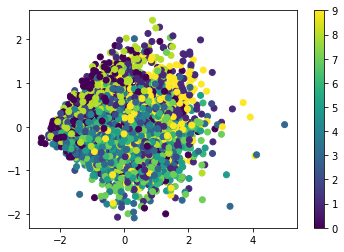

In [ ]:
pca = PCA(n_components=50)
pca.fit(sobel_after_mcc_train_x)
pca_train_x = pca.transform(sobel_after_mcc_train_x)
pca_test_x = pca.transform(sobel_after_mcc_test_x)

# plot the PCA results
plt.scatter(pca_train_x[:, 0], pca_train_x[:, 1], c=train_y)
plt.colorbar()
plt.show()

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best',max_depth=None)
lr = LogisticRegression(C=0.1, dual=False, penalty='l2', random_state=1)
svc = SVC(C=2, kernel='rbf', random_state=1)
gnb = GaussianNB(var_smoothing=0)

In [ ]:
dt.fit(pca_train_x,train_y)
lr.fit(pca_train_x,train_y)
svc.fit(pca_train_x,train_y)
gnb.fit(pca_train_x,train_y)

GaussianNB(var_smoothing=0)

In [ ]:
print(f'Decision Tree F1 score on train data is {f1_score(train_y,dt.predict(pca_train_x),average="micro")}')
print(f'Logistic Regression F1 score on train data is {f1_score(train_y,lr.predict(pca_train_x),average="micro")}')
print(f'SVC F1 score on train data is {f1_score(train_y,svc.predict(pca_train_x),average="micro")}')
print(f'GaussianNB F1 score on train data is {f1_score(train_y,gnb.predict(pca_train_x),average="micro")}')

Decision Tree F1 score on train data is 1.0
Logistic Regression F1 score on train data is 0.3276
SVC F1 score on train data is 0.776
GaussianNB F1 score on train data is 0.281


In [ ]:
print(f'Decision Tree F1 score on test data is {f1_score(test_y,dt.predict(pca_test_x),average="micro")}')
print(f'Logistic Regression F1 score on test data is {f1_score(test_y,lr.predict(pca_test_x),average="micro")}')
print(f'SVC F1 score on test data is {f1_score(test_y,svc.predict(pca_test_x),average="micro")}')
print(f'GaussianNB F1 score on test data is {f1_score(test_y,gnb.predict(pca_test_x),average="micro")}')

Decision Tree F1 score on test data is 0.16
Logistic Regression F1 score on test data is 0.288
SVC F1 score on test data is 0.37
GaussianNB F1 score on test data is 0.23


This actually improves the test scores of some of our models. Now let's tune PCA and set the most optimal number of dimensions. Firstly, we will construct a Stacking model and tune the PCA based on the new model results.

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best',max_depth=None)
lr = LogisticRegression(C=0.1, dual=False, penalty='l2', random_state=1)
svc = SVC(C=2, kernel='rbf', random_state=1)
gnb = GaussianNB(var_smoothing=0)
clf = StackingClassifier(estimators=[('gnb', gnb), ('lr', lr),('svc',svc),('dt',dt)], final_estimator=LogisticRegression(random_state=0))

In [ ]:
clf.fit(pca_train_x, train_y)
pred = clf.predict(pca_test_x)

print (f'Stacked models F1 score on test data = {f1_score(test_y, pred,average="micro")*100}')
print (f'Stacked models Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

Stacked models F1 score on test data = 34.9
Stacked models Classification Report 
               precision    recall  f1-score   support

           0       0.49      0.43      0.46       108
           1       0.39      0.39      0.39       116
           2       0.32      0.37      0.34        93
           3       0.29      0.05      0.09       117
           4       0.36      0.44      0.40        89
           5       0.29      0.28      0.29        95
           6       0.33      0.42      0.37        93
           7       0.34      0.37      0.35       103
           8       0.33      0.45      0.38        86
           9       0.32      0.36      0.34       100

    accuracy                           0.35      1000
   macro avg       0.35      0.36      0.34      1000
weighted avg       0.35      0.35      0.34      1000



In [ ]:
sobel_after_mcc_train_x[0].shape

(1024,)

In [ ]:
def find_best_pca_param(comp_number):
  pca = PCA(n_components=comp_number)
  pca.fit(sobel_after_mcc_train_x)
  pca_train_x = pca.transform(sobel_after_mcc_train_x)
  pca_test_x = pca.transform(sobel_after_mcc_test_x)

  dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best',max_depth=None)
  lr = LogisticRegression(C=0.1, dual=False, penalty='l2', random_state=1)
  svc = SVC(C=2, kernel='rbf', random_state=1)
  gnb = GaussianNB(var_smoothing=0)
  clf = StackingClassifier(estimators=[('gnb', gnb), ('lr', lr),('svc',svc),('dt',dt)], final_estimator=LogisticRegression(random_state=0))  
  clf.fit(pca_train_x, train_y)
  pred = clf.predict(pca_test_x)
  return f1_score(test_y, pred,average="micro")*100

In [ ]:
scores=[]
    
for k in range(10,1000,50):
    scores.append(find_best_pca_param(k))

In [ ]:
scores

[30.7,
 34.8,
 35.6,
 34.8,
 33.2,
 34.1,
 32.9,
 32.5,
 33.0,
 32.1,
 32.800000000000004,
 32.5,
 31.6,
 31.7,
 32.6,
 32.1,
 33.5,
 33.5,
 33.6,
 33.6]

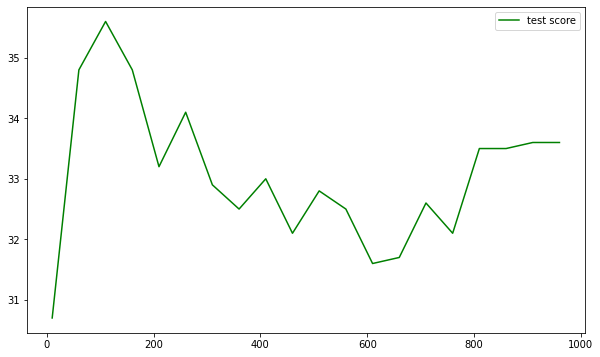

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(10,1000,50), scores, color='green', label='test score')
plt.legend()

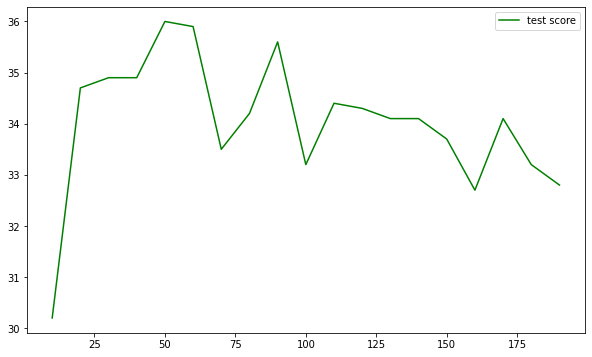

In [ ]:
scores=[]
    
for k in range(10,200,10):
    scores.append(find_best_pca_param(k))

plt.figure(figsize=(10, 6))
plt.plot(range(10,200,10), scores, color='green', label='test score')
plt.legend()

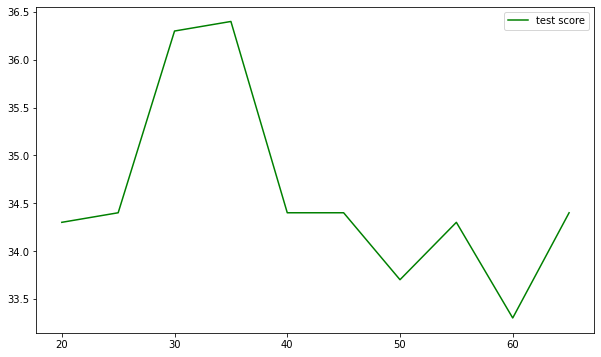

In [ ]:
scores=[]
    
for k in range(20,70,5):
    scores.append(find_best_pca_param(k))

plt.figure(figsize=(10, 6))
plt.plot(range(20,70,5), scores, color='green', label='test score')
plt.legend()

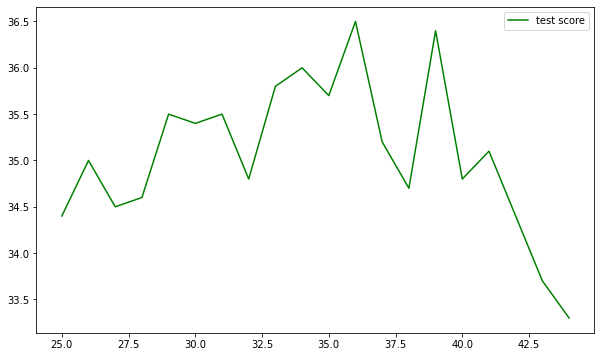

In [ ]:
scores=[]
    
for k in range(25,45):
    scores.append(find_best_pca_param(k))

plt.figure(figsize=(10, 6))
plt.plot(range(25,45), scores, color='green', label='test score')
plt.legend()

In [ ]:
  dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best',max_depth=None)
  lr = LogisticRegression(C=0.1, dual=False, penalty='l2', random_state=1)
  svc = SVC(C=2, kernel='rbf', random_state=1)
  gnb = GaussianNB(var_smoothing=0)
  clf = StackingClassifier(estimators=[('gnb', gnb), ('lr', lr),('svc',svc),('dt',dt)], final_estimator=LogisticRegression(random_state=0))  
  clf.fit(sobel_after_mcc_train_x, train_y)
  pred = clf.predict(sobel_after_mcc_test_x)
  print (f'Stacked models F1 score on test data without dimension reduction = {f1_score(test_y, pred,average="micro")*100}')

Stacked models F1 score on test data without dimension reduction = 34.5


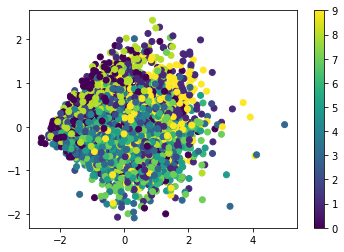

In [ ]:
pca = PCA(n_components=36)
pca.fit(sobel_after_mcc_train_x)
pca_train_x = pca.transform(sobel_after_mcc_train_x)
pca_test_x = pca.transform(sobel_after_mcc_test_x)

# plot the PCA results
plt.scatter(pca_train_x[:, 0], pca_train_x[:, 1], c=train_y)
plt.colorbar()
plt.show()

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best',max_depth=None)
lr = LogisticRegression(C=0.1, dual=False, penalty='l2', random_state=1)
svc = SVC(C=2, kernel='rbf', random_state=1)
gnb = GaussianNB(var_smoothing=0)
clf = StackingClassifier(estimators=[('gnb', gnb), ('lr', lr),('svc',svc),('dt',dt)], final_estimator=LogisticRegression(random_state=0))

In [ ]:
clf.fit(pca_train_x, train_y)
pred = clf.predict(pca_test_x)

print (f'Stacked models F1 score on test data = {f1_score(test_y, pred,average="micro")*100}')
print (f'Stacked models Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

Stacked models F1 score on test data = 35.800000000000004
Stacked models Classification Report 
               precision    recall  f1-score   support

           0       0.49      0.38      0.43       108
           1       0.40      0.41      0.41       116
           2       0.30      0.38      0.33        93
           3       0.53      0.08      0.13       117
           4       0.41      0.49      0.45        89
           5       0.28      0.27      0.28        95
           6       0.35      0.45      0.39        93
           7       0.33      0.34      0.33       103
           8       0.36      0.47      0.40        86
           9       0.31      0.38      0.34       100

    accuracy                           0.36      1000
   macro avg       0.38      0.37      0.35      1000
weighted avg       0.38      0.36      0.35      1000



This dimension reduction significantly improves the score of the model.

## Picking the best Ensemble algorithm
### Stacking

In [ ]:
sobel_after_mcc_train_x = [apply_sobel_after_mean_color(img) for img in train_x]
sobel_after_mcc_test_x = [apply_sobel_after_mean_color(img) for img in test_x]

In [ ]:
pca = PCA(n_components=36)
pca.fit(sobel_after_mcc_train_x)
pca_train_x = pca.transform(sobel_after_mcc_train_x)
pca_test_x = pca.transform(sobel_after_mcc_test_x)

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best',max_depth=None)
lr = LogisticRegression(C=0.1, dual=False, penalty='l2', random_state=1)
svc = SVC(C=2, kernel='rbf', random_state=1)
gnb = GaussianNB(var_smoothing=0)
stacking = StackingClassifier(estimators=[('gnb', gnb), ('lr', lr),('svc',svc),('dt',dt)], final_estimator=LogisticRegression(random_state=0))

In [ ]:
stacking.fit(pca_train_x, train_y)
pred = stacking.predict(pca_test_x)

print (f'Stacked models F1 score on test data = {f1_score(test_y, pred,average="micro")*100}')
print (f'Stacked models Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

Stacked models F1 score on test data = 35.50000000000001
Stacked models Classification Report 
               precision    recall  f1-score   support

           0       0.54      0.41      0.46       108
           1       0.40      0.40      0.40       116
           2       0.31      0.39      0.34        93
           3       0.31      0.04      0.08       117
           4       0.40      0.53      0.46        89
           5       0.26      0.26      0.26        95
           6       0.35      0.40      0.37        93
           7       0.34      0.35      0.34       103
           8       0.34      0.47      0.40        86
           9       0.30      0.39      0.34       100

    accuracy                           0.36      1000
   macro avg       0.36      0.36      0.34      1000
weighted avg       0.36      0.35      0.34      1000



### Voting

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best',max_depth=None)
lr = LogisticRegression(C=0.1, dual=False, penalty='l2', random_state=1)
svc = SVC(C=2, kernel='rbf', random_state=1)
gnb = GaussianNB(var_smoothing=0)
voting = VotingClassifier(estimators=[('dt', dt), ('lr', lr), ('svc', svc), ('gnb', gnb)], voting='hard')

In [ ]:
voting.fit(pca_train_x, train_y)
pred = voting.predict(pca_test_x)

print (f'Voting classifier F1 score on test data = {f1_score(test_y, pred,average="micro")*100}')
print (f'Voting classifier Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

Voting classifier F1 score on test data = 33.4
Voting classifier Classification Report 
               precision    recall  f1-score   support

           0       0.39      0.45      0.42       108
           1       0.35      0.43      0.38       116
           2       0.29      0.40      0.33        93
           3       0.30      0.15      0.20       117
           4       0.33      0.46      0.38        89
           5       0.26      0.18      0.21        95
           6       0.28      0.27      0.27        93
           7       0.36      0.31      0.33       103
           8       0.33      0.42      0.37        86
           9       0.43      0.30      0.36       100

    accuracy                           0.33      1000
   macro avg       0.33      0.34      0.33      1000
weighted avg       0.33      0.33      0.33      1000



### Bagging

In [ ]:
svc = SVC(C=2, kernel='rbf', random_state=1)
bagging = BaggingClassifier(base_estimator=svc, n_estimators=50, random_state=1)

In [ ]:
bagging.fit(pca_train_x, train_y)
pred = bagging.predict(pca_test_x)

print (f'Bagging classifier F1 score on test data = {f1_score(test_y, pred,average="micro")*100}')
print (f'Bagging classifier Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

Bagging classifier F1 score on test data = 37.6
Bagging classifier Classification Report 
               precision    recall  f1-score   support

           0       0.46      0.48      0.47       108
           1       0.40      0.42      0.41       116
           2       0.34      0.35      0.35        93
           3       0.37      0.22      0.28       117
           4       0.36      0.49      0.42        89
           5       0.28      0.22      0.25        95
           6       0.35      0.40      0.37        93
           7       0.39      0.30      0.34       103
           8       0.40      0.45      0.43        86
           9       0.36      0.44      0.40       100

    accuracy                           0.38      1000
   macro avg       0.37      0.38      0.37      1000
weighted avg       0.37      0.38      0.37      1000



### Boosting

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best',max_depth=None)
boosting = AdaBoostClassifier(base_estimator=dt, n_estimators=50, random_state=1)

In [ ]:
boosting.fit(pca_train_x, train_y)
pred = boosting.predict(pca_test_x)

print (f'Boosting classifier F1 score on test data = {f1_score(test_y, pred,average="micro")*100}')
print (f'Boosting classifier Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

Boosting classifier F1 score on test data = 19.2
Boosting classifier Classification Report 
               precision    recall  f1-score   support

           0       0.21      0.19      0.20       108
           1       0.26      0.27      0.26       116
           2       0.16      0.15      0.15        93
           3       0.25      0.21      0.23       117
           4       0.14      0.16      0.15        89
           5       0.18      0.18      0.18        95
           6       0.14      0.13      0.13        93
           7       0.18      0.19      0.19       103
           8       0.19      0.23      0.21        86
           9       0.19      0.18      0.18       100

    accuracy                           0.19      1000
   macro avg       0.19      0.19      0.19      1000
weighted avg       0.19      0.19      0.19      1000



### Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=50, random_state=1)

In [ ]:
rf.fit(pca_train_x, train_y)
pred = rf.predict(pca_test_x)

print (f'Random Forest Classifier F1 score on test data = {f1_score(test_y, pred,average="micro")*100}')
print (f'Random Forest Classifier Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

Random Forest Classifier F1 score on test data = 30.8
Random Forest Classifier Classification Report 
               precision    recall  f1-score   support

           0       0.48      0.38      0.42       108
           1       0.37      0.43      0.40       116
           2       0.30      0.34      0.32        93
           3       0.19      0.10      0.13       117
           4       0.30      0.34      0.32        89
           5       0.24      0.25      0.25        95
           6       0.27      0.33      0.30        93
           7       0.33      0.26      0.29       103
           8       0.29      0.40      0.34        86
           9       0.28      0.27      0.28       100

    accuracy                           0.31      1000
   macro avg       0.30      0.31      0.30      1000
weighted avg       0.31      0.31      0.30      1000



We see that the bagging model has the best results. That is why we will tune its features.

### Tuning the Bagging model

In [ ]:
scores = []
for n in [2,25,50,75,100]:
  svc = SVC(C=2, kernel='rbf', random_state=1)
  bagging = BaggingClassifier(base_estimator=svc, n_estimators=n, random_state=1)
  bagging.fit(pca_train_x, train_y)
  pred = bagging.predict(pca_test_x)
  current_score = f1_score(test_y, pred,average="micro")*100
  print(f'Bagging model score with {n} estimators is {current_score}')
  scores.append(current_score)

Bagging model score with 2 estimators is 34.300000000000004
Bagging model score with 25 estimators is 37.7
Bagging model score with 50 estimators is 37.6
Bagging model score with 75 estimators is 38.1
Bagging model score with 100 estimators is 37.8


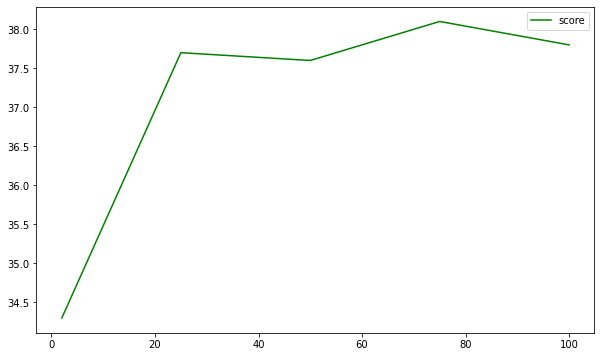

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([2,25,50,75,100], scores, color='green', label='score')
plt.legend()

As we can see the increase from point to point starts to decrease after 50. So we will not take a look at values like 200,300 because the increase might not be as big as we want and the computational power is limited.

# Final test

### Models scores without tuning and preprocessing

In [ ]:
batch_size_train= len(train_set)
batch_size_test=len(test_set)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=batch_size_test, shuffle=True)

In [ ]:
train_enumerated = enumerate(train_loader)
batch_idx, (train_x, train_y) = next(train_enumerated)

test_enumerated = enumerate(test_loader)
batch_idx, (test_x, test_y) = next(test_enumerated)

In [ ]:
train_x = [torch.flatten(x).numpy() for x in train_x]
test_x = [torch.flatten(x).numpy() for x in test_x]

#### SVC

In [ ]:
svc = SVC(random_state=1)
svc.fit(train_x, train_y)

SVC(random_state=1)

In [ ]:
pred = svc.predict(test_x)

In [ ]:
print (f'SVC F1 score on test data = {f1_score(test_y, pred,average="micro")*100}')
print (f'SVC Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

SVC F1 score on test data = 44.760000000000005
SVC Classification Report 
               precision    recall  f1-score   support

           0       0.53      0.53      0.53      1000
           1       0.54      0.51      0.53      1000
           2       0.33      0.31      0.32      1000
           3       0.32      0.31      0.32      1000
           4       0.39      0.36      0.37      1000
           5       0.40      0.34      0.37      1000
           6       0.44      0.54      0.49      1000
           7       0.51      0.43      0.47      1000
           8       0.54      0.61      0.57      1000
           9       0.46      0.51      0.48      1000

    accuracy                           0.45     10000
   macro avg       0.45      0.45      0.45     10000
weighted avg       0.45      0.45      0.45     10000



### Models scores with tuning and preprocessing

#### Stacked models

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best',max_depth=None)
lr = LogisticRegression(C=0.1, dual=False, penalty='l2', random_state=1)
svc = SVC(C=2, kernel='rbf', random_state=1)
gnb = GaussianNB(var_smoothing=0)
clf = StackingClassifier(estimators=[('gnb', gnb), ('lr', lr),('svc',svc),('dt',dt)], final_estimator=LogisticRegression(random_state=0))

In [ ]:
batch_size_train= len(train_set)
batch_size_test=len(test_set)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=batch_size_test, shuffle=True)

In [ ]:
train_enumerated = enumerate(train_loader)
batch_idx, (train_x, train_y) = next(train_enumerated)

test_enumerated = enumerate(test_loader)
batch_idx, (test_x, test_y) = next(test_enumerated)

In [ ]:
sobel_after_mcc_train_x = [apply_sobel_after_mean_color(img) for img in train_x]
sobel_after_mcc_test_x = [apply_sobel_after_mean_color(img) for img in test_x]

In [ ]:
pca = PCA(n_components=36)
pca.fit(sobel_after_mcc_train_x)
pca_train_x = pca.transform(sobel_after_mcc_train_x)
pca_test_x = pca.transform(sobel_after_mcc_test_x)

In [ ]:
clf.fit(pca_train_x, train_y)
pred = clf.predict(pca_test_x)

print (f'Stacked models F1 score on test data = {f1_score(test_y, pred,average="micro")*100}')
print (f'Stacked models Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

Stacked models F1 score on test data = 43.080000000000005
Stacked models Classification Report 
               precision    recall  f1-score   support

           0       0.51      0.50      0.51      1000
           1       0.48      0.53      0.50      1000
           2       0.41      0.35      0.38      1000
           3       0.31      0.11      0.16      1000
           4       0.40      0.43      0.41      1000
           5       0.35      0.33      0.34      1000
           6       0.42      0.55      0.48      1000
           7       0.47      0.50      0.48      1000
           8       0.46      0.53      0.49      1000
           9       0.42      0.48      0.45      1000

    accuracy                           0.43     10000
   macro avg       0.42      0.43      0.42     10000
weighted avg       0.42      0.43      0.42     10000



#### CNN

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(relu(self.conv1(x)))
        x = self.pool(relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = relu(self.fc1(x))
        x = relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

train_set = torchvision.datasets.CIFAR10(root='./files/cifar10/', train=True, download=False, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./files/cifar10/', train=False, download=False, transform=transform)

train_set, valid_set = random_split(train_set,[40000,10000])

train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=128, shuffle=True, num_workers=4)

valid_loader = torch.utils.data.DataLoader(
  valid_set,
  batch_size=128, shuffle=True, num_workers=4)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=128, shuffle=True)

cnn = Net()

calculate_loss = nn.CrossEntropyLoss()
optimizer = Adam(cnn.parameters(), lr=0.001)

In [ ]:
num_iterations = 400
training_losses=[]
validation_losses=[]

for epoch in range(num_iterations):

  running_train_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    optimizer.zero_grad()


    train_predictions = cnn(inputs)
    current_train_loss = calculate_loss(train_predictions, labels)
    current_train_loss.backward()
    optimizer.step()

    running_train_loss += current_train_loss.item()
  
  running_valid_loss = 0.0
  for i, data in enumerate(valid_loader, 0):
    inputs, labels = data
    valid_predictions = cnn(inputs)
    current_valid_loss = calculate_loss(valid_predictions, labels)
    running_valid_loss += current_valid_loss.item()


  print(f'[{epoch + 1}] training loss: {running_train_loss/4:.3f}, validation loss: {running_valid_loss:.3f}')
  training_losses.append(running_train_loss/4)
  validation_losses.append(running_valid_loss)

  if (epoch+1)%20==0:
    PATH = f'./cifar_net_epoch_{epoch+1}.pth'
    torch.save(cnn.state_dict(), PATH)
  

print('Finished Training')

[1] training loss: 154.322, validation loss: 141.819
[2] training loss: 133.761, validation loss: 129.863
[3] training loss: 126.538, validation loss: 124.119
[4] training loss: 122.588, validation loss: 126.542
[5] training loss: 119.356, validation loss: 119.453
[6] training loss: 116.648, validation loss: 117.412
[7] training loss: 113.590, validation loss: 112.585
[8] training loss: 110.569, validation loss: 109.934
[9] training loss: 108.171, validation loss: 107.074
[10] training loss: 105.787, validation loss: 104.766
[11] training loss: 104.971, validation loss: 104.629
[12] training loss: 102.937, validation loss: 103.671
[13] training loss: 101.719, validation loss: 101.772
[14] training loss: 99.655, validation loss: 101.049
[15] training loss: 98.873, validation loss: 99.028
[16] training loss: 98.230, validation loss: 98.259
[17] training loss: 97.226, validation loss: 98.830
[18] training loss: 95.809, validation loss: 96.867
[19] training loss: 95.381, validation loss: 9

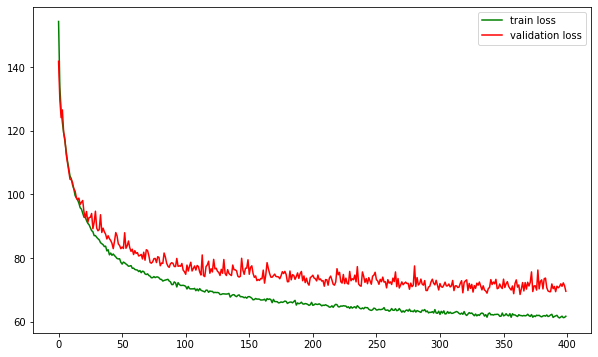

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_iterations), training_losses, color='green', label='train loss')
plt.plot(range(num_iterations), validation_losses, color='red', label='validation loss')
plt.legend()

In [ ]:
mean_training_losses =[]
mean_valid_losses = [] 
for i in range((int)(num_iterations/4)):
  mean_training_losses.append(sum(training_losses[i*4:i*4+4])/4)
  mean_valid_losses.append(sum(validation_losses[i*4:i*4+4])/4)


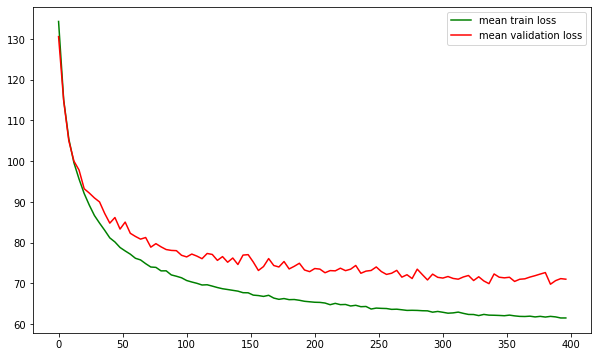

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(0,num_iterations,4), mean_training_losses, color='green', label='mean train loss')
plt.plot(range(0,num_iterations,4), mean_valid_losses, color='red', label='mean validation loss')
plt.legend()

We can see that the validation loss does not decrease. That is why we will stop the training. However, it has also not increased. So, we will save the latest model.

In [ ]:
PATH = './cifar_net.pth'

In [ ]:
torch.save(cnn.state_dict(), PATH)

In [ ]:
cnn = Net()
cnn.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
    cnn.eval()
    predictions = []
    ground_truth = []
    for images, labels in test_loader:
        images, labels = data
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.numpy())
        ground_truth.extend(labels.numpy())
    
    # Calculate the F1 score
    f1 = f1_score(ground_truth, predictions, average='macro')
    print (f'CNN F1 score on test data = {f1_score(ground_truth, predictions,average="micro")*100}')
    print (f'CNN Classification Report \n {classification_report(ground_truth, predictions, labels=range(0,10))}')

CNN F1 score on test data = 75.0
CNN Classification Report 
               precision    recall  f1-score   support

           0       1.00      0.50      0.67       158
           1       1.00      1.00      1.00       158
           2       1.00      1.00      1.00        79
           3       0.33      0.50      0.40       158
           4       1.00      1.00      1.00        79
           5       1.00      0.75      0.86       316
           6       0.00      0.00      0.00        79
           7       1.00      1.00      1.00       158
           8       0.50      1.00      0.67        79
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75      1264
   macro avg       0.68      0.68      0.66      1264
weighted avg       0.82      0.75      0.76      1264



In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
predictions = []
test_y = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = cnn(images)
        _, predict = torch.max(outputs, 1)
        for label, prediction in zip(labels, predict):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            predictions.append(prediction)
            test_y.append(label)


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 76.4 %
Accuracy for class: car   is 85.9 %
Accuracy for class: bird  is 59.0 %
Accuracy for class: cat   is 46.3 %
Accuracy for class: deer  is 65.2 %
Accuracy for class: dog   is 59.5 %
Accuracy for class: frog  is 77.1 %
Accuracy for class: horse is 75.9 %
Accuracy for class: ship  is 82.0 %
Accuracy for class: truck is 73.2 %


In [ ]:
test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=len(test_set), shuffle=True)

test_enumerated = enumerate(test_loader)
batch_idx, (test_x, test_y) = next(test_enumerated)
with torch.no_grad():
  outputs = cnn(test_x)
  _, predict = torch.max(outputs, 1)
print (f'CNN F1 score on test data = {f1_score(test_y, predict,average="micro")*100}')
print (f'CNN Classification Report \n {classification_report(test_y, predict, labels=range(0,10))}')

CNN F1 score on test data = 69.61
CNN Classification Report 
               precision    recall  f1-score   support

           0       0.70      0.76      0.73      1000
           1       0.77      0.84      0.80      1000
           2       0.60      0.60      0.60      1000
           3       0.53      0.46      0.49      1000
           4       0.66      0.64      0.65      1000
           5       0.59      0.58      0.58      1000
           6       0.76      0.79      0.77      1000
           7       0.74      0.77      0.76      1000
           8       0.79      0.80      0.79      1000
           9       0.79      0.72      0.76      1000

    accuracy                           0.70     10000
   macro avg       0.69      0.70      0.69     10000
weighted avg       0.69      0.70      0.69     10000



#### Bagging model

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = torchvision.datasets.CIFAR10(root='./files/cifar10/', train=False, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./files/cifar10/', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size_train= len(train_set)
batch_size_test=len(test_set)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=batch_size_test, shuffle=True)

In [ ]:
train_enumerated = enumerate(train_loader)
batch_idx, (train_x, train_y) = next(train_enumerated)

test_enumerated = enumerate(test_loader)
batch_idx, (test_x, test_y) = next(test_enumerated)

In [ ]:
train_x.shape

torch.Size([10000, 3, 32, 32])

In [ ]:
sobel_after_mcc_train_x = [apply_sobel_after_mean_color(img) for img in train_x]
sobel_after_mcc_test_x = [apply_sobel_after_mean_color(img) for img in test_x]
pca = PCA(n_components=36)
pca.fit(sobel_after_mcc_train_x)
pca_train_x = pca.transform(sobel_after_mcc_train_x)
pca_test_x = pca.transform(sobel_after_mcc_test_x)

In [ ]:
svc = SVC(C=2, kernel='rbf', random_state=1)
bagging = BaggingClassifier(base_estimator=svc, n_estimators=100, random_state=1)

bagging.fit(pca_train_x, train_y)
pred = bagging.predict(pca_test_x)

In [ ]:
print (f'Bagging model F1 score on test data = {f1_score(test_y, pred,average="micro")*100}')
print (f'Bagging model Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

Bagging model F1 score on test data = 73.75
Bagging model Classification Report 
               precision    recall  f1-score   support

           0       0.78      0.79      0.79      1000
           1       0.83      0.84      0.84      1000
           2       0.69      0.63      0.66      1000
           3       0.75      0.64      0.69      1000
           4       0.55      0.69      0.61      1000
           5       0.78      0.66      0.72      1000
           6       0.61      0.75      0.68      1000
           7       0.84      0.76      0.80      1000
           8       0.76      0.79      0.78      1000
           9       0.87      0.81      0.84      1000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000



#### SVC

In [ ]:
svc = SVC(C=2, kernel='rbf', random_state=1)
svc.fit(pca_train_x, train_y)

SVC(C=2, random_state=1)

In [ ]:
pred = svc.predict(pca_test_x)

In [ ]:
print (f'SVC F1 score on test data = {f1_score(test_y, pred,average="micro")*100}')
print (f'SVC Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

SVC F1 score on test data = 70.48
SVC Classification Report 
               precision    recall  f1-score   support

           0       0.77      0.77      0.77      1000
           1       0.82      0.80      0.81      1000
           2       0.67      0.58      0.62      1000
           3       0.69      0.60      0.64      1000
           4       0.52      0.67      0.59      1000
           5       0.73      0.63      0.67      1000
           6       0.59      0.73      0.65      1000
           7       0.80      0.73      0.77      1000
           8       0.73      0.75      0.74      1000
           9       0.82      0.78      0.80      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.71     10000
weighted avg       0.71      0.70      0.71     10000



# Final Results

In [ ]:
data = {'Model':  ['SVC without tuning and preprocessing', 'Stacking model','SVC', 'Bagging model','CNN'],
        'F1 Score': [44.760000000000005,43.080000000000005 ,70.48,73.75,69.61],
        }

df = pd.DataFrame(data)
print(df)

                                  Model  F1 Score
0  SVC without tuning and preprocessing     44.76
1                        Stacking model     43.08
2                                   SVC     70.48
3                         Bagging model     73.75
4                                   CNN     69.61


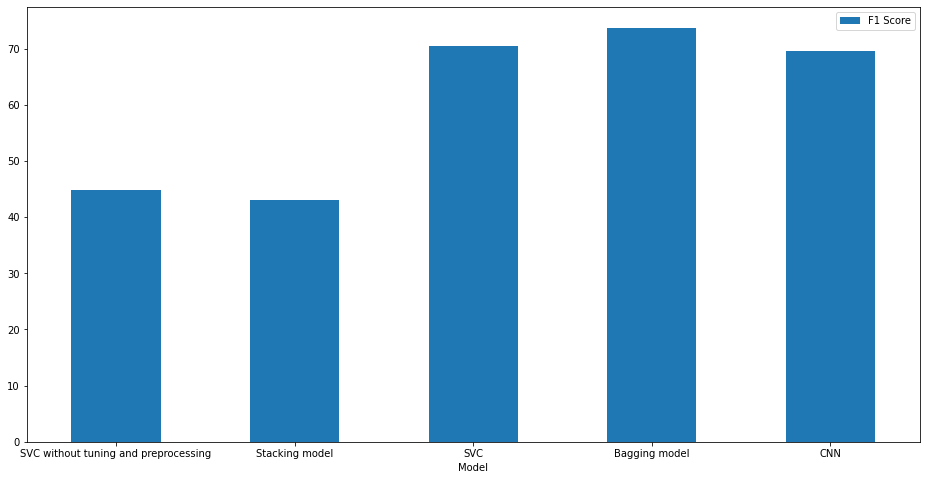

In [ ]:
barplot = df.plot.bar(x='Model', y='F1 Score', rot=0, figsize=(16,8))

### Conclusion

As we can see the preprocessing dramatically imporves the results of the algorithms. The machine learning algorithms might not be the best choice for image classification. However, with good feature extraction and parameters tuning they can do a pretty good job on complex datasets like CIFAR-10.